# Import Useful Libraries

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import time
from datetime import timedelta

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

## Copy some of the data-dimensions for convenience.
img_size_flat is the number of pixels in an image when the image is flattened, img_size_flat = 28 * 28 = 784.

img_shape is the shape of an image in 2-D, img_shape = 28 * 28 (28 by 28).

num_classes is the number of output classes for the images, num_classes = 10

In [3]:
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes

## Define the placeholders for feeding the training and testing data to the computational graph
x is a placeholder variable whose dimensions are [None, img_size_flat] through which the images are fed to the model for training as well as testing.

y_true is the placeholder through which the correct class for a training or testing data is fed to the network.

In [4]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes]) # y_true is a one-hot vector of class labels
y_true_cls = tf.argmax(y_true, axis =1) # not a placeholder, y_true cls contains the class label as an integral value

## Define the dimensions of the model
Our model is a multi-layer perceptron with 4 hidden layers having 1000, 1000, 500 and 200 neurons respectively. For ease of simplicity, biases are not used in the model.

In [5]:
hidden1 = 1000
hidden2 = 1000
hidden3 = 500
hidden4 = 200

## Variables to be optimized
w1-w5 are 5 trainable variables(weight matrices) that will be optimized during the training.

In [6]:
w1 = tf.Variable(tf.truncated_normal([img_size_flat,hidden1], stddev = 0.05, seed=25))
h1 = tf.nn.relu(tf.matmul(x,w1))

w2 = tf.Variable(tf.truncated_normal([hidden1,hidden2],stddev = 0.05, seed=25))
h2 = tf.nn.relu(tf.matmul(h1,w2))

w3 = tf.Variable(tf.truncated_normal([hidden2,hidden3], stddev = 0.05, seed=25))
h3 = tf.nn.relu(tf.matmul(h2,w3))

w4 = tf.Variable(tf.truncated_normal([hidden3,hidden4],stddev = 0.05, seed=25))
h4 = tf.nn.relu(tf.matmul(h3,w4))

w5 = tf.Variable(tf.truncated_normal([hidden4,num_classes], stddev = 0.05, seed=25))
logits = tf.matmul(h4,w5)

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

## Calculation of model loss
To quantify the performance of the model, a cross-entropy loss is defined over the oputput of the model and true class values.

In [7]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Define optimization and accuracy operation

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create a tensorflow session and initialize all the variables

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
batch_size = 100

## Define a function for carrying out iterations to train the model

In [11]:
def optimize(optimizer, num_iterations):
        
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [12]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

## Define a function to print the accuracy over the test set

In [13]:
def print_accuracy():
    
    start_time = time.time()
    
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    end_time = time.time()
    
    timedelta = (end_time-start_time)*1000
    print("Execution time in milliseconds: {0:.4}".format(timedelta))
    
    return acc, timedelta

In [14]:
optimize(optimizer, num_iterations=2000)

In [15]:
original_accuracy, execution_time = print_accuracy()

Accuracy on test-set: 97.5%
Execution time in milliseconds: 924.6


# Implementation of weight pruning

In [16]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [17]:
def weight_pruning(sparsity):

    accuracy_weight_pruning = []
    
    for k in sparsity:
    
        # First, perform weight pruning by setting lower k weights in each layer(by magnitude) to 0.
        # Set the lower k weight values to 0, reshape the numpy vector to the shape of the
        # original corresponding weight vector and convert the weight vector back to a tensor.    
    
    
        wt1 = np.ndarray.flatten(np.asarray(session.run(w1)))
        wt2 = np.ndarray.flatten(np.asarray(session.run(w2)))
        wt3 = np.ndarray.flatten(np.asarray(session.run(w3)))
        wt4 = np.ndarray.flatten(np.asarray(session.run(w4)))
        wt5 = np.asarray(session.run(w5))
        
        wt1[np.abs(wt1)<np.percentile(np.abs(wt1),k)] = 0
        wt2[np.abs(wt2)<np.percentile(np.abs(wt2),k)] = 0
        wt3[np.abs(wt3)<np.percentile(np.abs(wt3),k)] = 0
        wt4[np.abs(wt4)<np.percentile(np.abs(wt4),k)] = 0
    
    # The weight vectors obtained above are used to initialize the trainable parameters of the neural network.
    # The weight vectors are first reshaped into the shape corresponding to the layers they connect and then
    # converted to tensors so as to use them to initialize the weights of the neural network layers.
    
        wt1 = tf.Variable(tf.convert_to_tensor(wt1.reshape([img_size_flat,hidden1])))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2.reshape([hidden1,hidden2])))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3.reshape([hidden2,hidden3])))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4.reshape([hidden3,hidden4])))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
    # Apply softmax to logits to get predicted probabilities for each class and predicted class for 
    # each instance.
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy_wp = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
    
        acc = session.run(accuracy_wp, feed_dict = feed_dict_test)
        accuracy_weight_pruning.append(acc*100)
    
    return accuracy_weight_pruning
    
    #####################################################################################################

In [18]:
accuracy_weight_pruning = weight_pruning(sparsity)

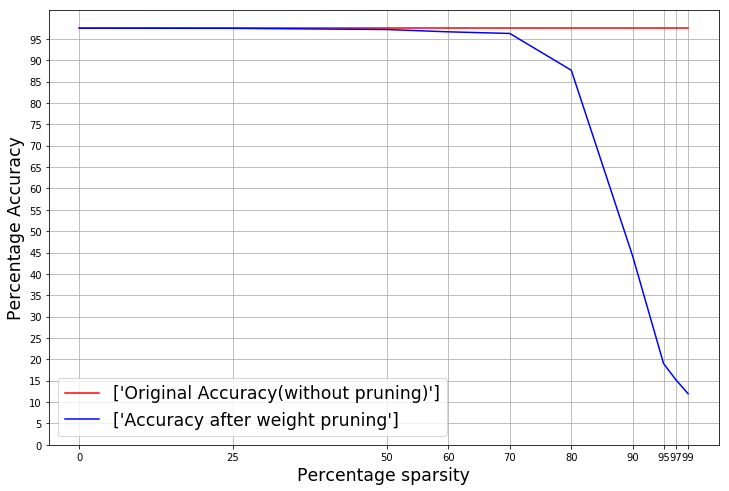

In [19]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r', sparsity,accuracy_weight_pruning,'b')
plt.grid()
plt.legend([['Original Accuracy(without pruning)'],['Accuracy after weight pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Percentage Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

# Implementation of neuron pruning

In [20]:
def neuron_pruning(sparsity):
    
    accuracy_neuron_pruning = []
    
    for k in sparsity:
        
        wt1 = np.asarray(session.run(w1))
        wt2 = np.asarray(session.run(w2))
        wt3 = np.asarray(session.run(w3))
        wt4 = np.asarray(session.run(w4))
        wt5 = np.asarray(session.run(w5))

        norm1 = LA.norm(wt1, axis=0)
        norm2 = LA.norm(wt2, axis=0)
        norm3 = LA.norm(wt3, axis=0)
        norm4 = LA.norm(wt4, axis=0)
        
        wt1[:,np.argwhere(norm1<np.percentile(norm1,k))] = 0
        wt2[:,np.argwhere(norm2<np.percentile(norm2,k))] = 0
        wt3[:,np.argwhere(norm3<np.percentile(norm3,k))] = 0
        wt4[:,np.argwhere(norm4<np.percentile(norm4,k))] = 0
        
        wt1 = tf.Variable(tf.convert_to_tensor(wt1))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
    
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        accuracy_np = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
    
        acc = session.run(accuracy_np, feed_dict = feed_dict_test)
        accuracy_neuron_pruning.append(acc*100)
    
    return accuracy_neuron_pruning

    #####################################################################################################
    

In [21]:
accuracy_neuron_pruning = neuron_pruning(sparsity)

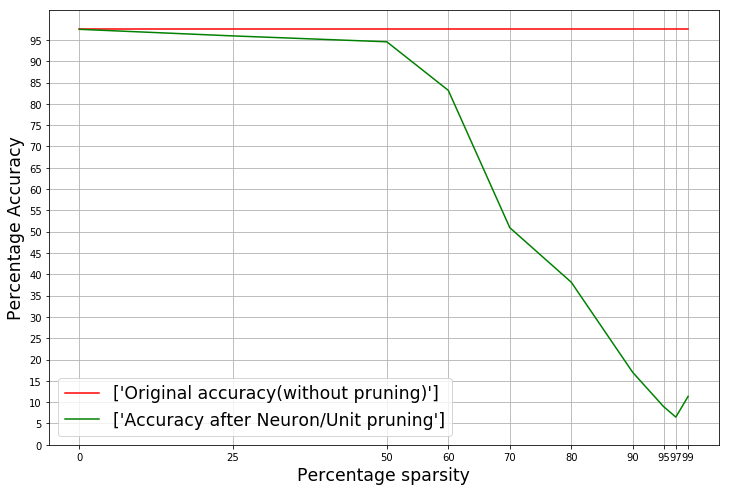

In [22]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r', sparsity,accuracy_neuron_pruning,'g')
plt.grid()
plt.legend([['Original accuracy(without pruning)'],['Accuracy after Neuron/Unit pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Percentage Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

# Comparing weight pruning and unit/neuron pruning

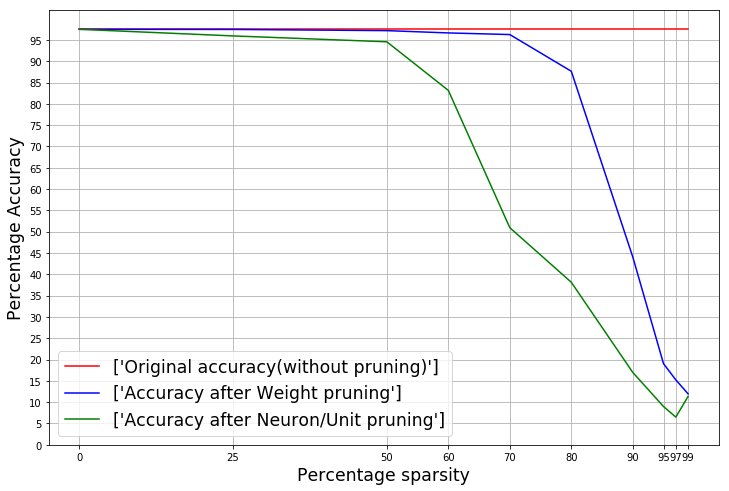

In [23]:
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r',
         sparsity, accuracy_weight_pruning,'b',sparsity,accuracy_neuron_pruning,'g')
plt.grid()
plt.legend([['Original accuracy(without pruning)'],['Accuracy after Weight pruning'],\
            ['Accuracy after Neuron/Unit pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Percentage Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

# Conclusions

i) As the sparsity increases from 0 to 50%, there is a very small decrease in accuracy. This means that at least half of the neurons in a neural network are redundant and do not contribute to accuracy at all (the number of redundant neurons is higher in case of neuron pruning as compared to weight pruning).

ii) Neuron pruning shows a significantly faster drop in accuracy as compared to weight pruning. The reason for this is that for a sparsity of k%, k% of the weights become zero in case of weight pruning, whereas in neuron pruning k% of the neurons are deleted in each layer which leads to the deletion of lot more connections as compared to weight pruning with same sparsity.

iii) The presence of an excess of redundant neurons provides scope for decreasing the size of neural network while maintaining the same accuracy.

iv) By deleting the redundant neurons, we can also increase the execution time considerably (this analysis has been done in a separate jupyter notebook).